In [1]:
%load_ext lab_black
import admix
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
# SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp-tables.xlsx?dl=1"
SUPP_TABLE_URL = "supp-tables.xlsx"
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="ukb-trait-info")
ukb_trait_list = df_trait_info[df_trait_info["in-analysis"] == "T"].id.values
ukb_name_dict = (
    df_trait_info[["id", "display-name"]].set_index("id")["display-name"].to_dict()
)


df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="page-trait-info")
page_trait_list = df_trait_info.trait.values
page_name_dict = (
    df_trait_info[["trait", "display-name"]]
    .set_index("trait")["display-name"]
    .to_dict()
)

aou_name_dict = {
    "bmi": "BMI",
    "diastolic_blood_pressure": "Diastolic blood pressure",
    "systolic_blood_pressure": "Systolic blood pressure",
    "HDL": "HDL",
    "LDL_adjusted": "LDL",
    "heart_rate": "Heart rate",
    "height": "Height",
    "TC_adjusted": "Total cholesterol",
    "TG_adjusted": "Triglycerides",
    "waist_hip_ratio": "WHR",
}

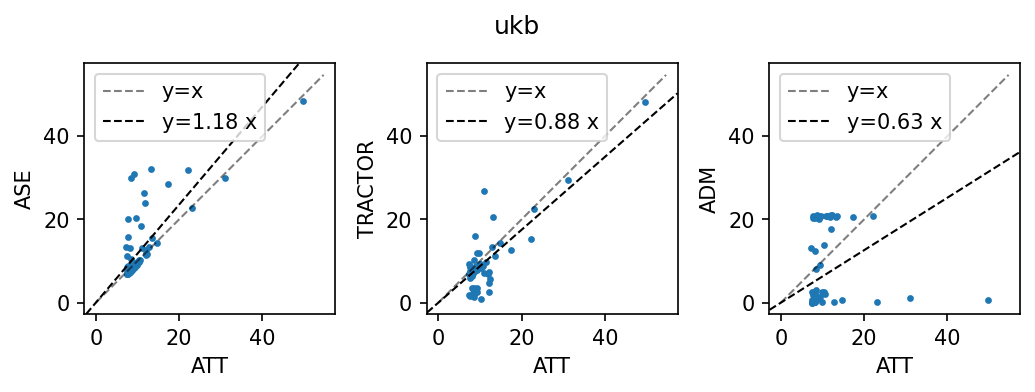

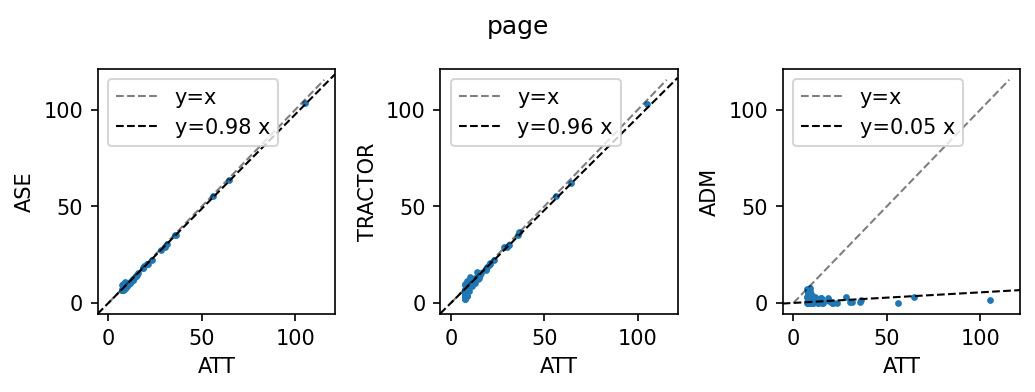

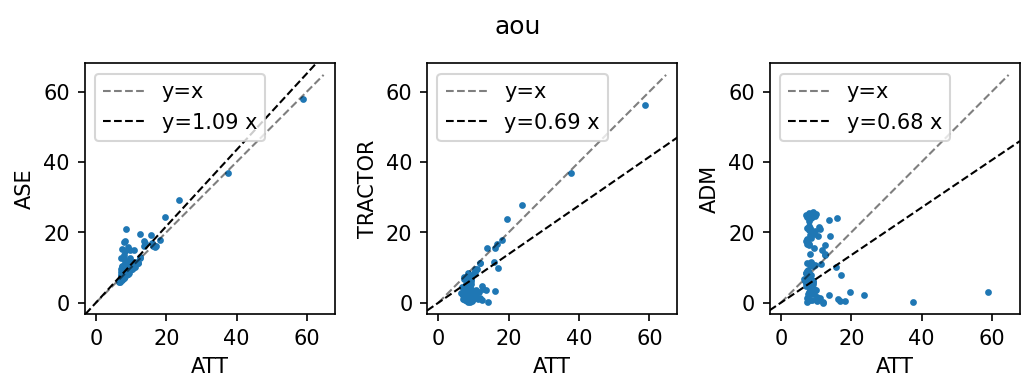

In [3]:
dict_df_het = {}
for study in ["ukb", "page", "aou"]:

    name_dict = {"page": page_name_dict, "ukb": ukb_name_dict, "aou": aou_name_dict}[
        study
    ]
    df = pd.read_csv(f"out/summary/{study}_het_info.tsv", sep="\t")
    df["CHROM"] = df.snp.apply(lambda x: int(x.split(":")[0][3:]))
    df["POS"] = df.snp.apply(lambda x: int(x.split(":")[1]))
    df["STUDY"] = study
    df["TRAIT"] = df["TRAIT"].apply(lambda t: name_dict[t])
    dict_df_het[study] = df

    fig, axes = plt.subplots(figsize=(7, 2.7), dpi=150, ncols=3)
    for i, m2 in enumerate(["ASE", "TRACTOR", "ADM"]):
        admix.plot.compare_pval(df["ATT_P"].values, df[m2 + "_P"].values, ax=axes[i])
        axes[i].set_xlabel("ATT")
        axes[i].set_ylabel(m2)
    plt.suptitle(study, y=0.95)
    plt.tight_layout()

In [4]:
df_tbl = pd.concat([dict_df_het[study] for study in dict_df_het])
df_tbl = df_tbl[df_tbl.ATT_P < 5e-8]
df_tbl["STUDY"] = df_tbl["STUDY"].apply(
    lambda x: {"ukb": "UKBB", "page": "PAGE", "aou": "AoU"}[x]
)

In [8]:
dict_column = {
    "STUDY": "study",
    "TRAIT": "trait",
    "snp": "snp",
    "CHROM": "chrom",
    "POS": "pos",
    "EUR_FREQ": "EUR_FREQ",
    "AFR_FREQ": "AFR_FREQ",
    "ATT_P": "assoc p-value",
    "HET_P": "HET p-value",
    "G1_BETA": "EUR_BETA",
    "G1_SE": "EUR_SE",
    "G2_BETA": "AFR_BETA",
    "G2_SE": "AFR_SE",
}

In [9]:
df_tbl.rename(columns=dict_column)[dict_column.values()].sort_values(
    ["study", "trait", "chrom", "pos"]
).to_excel("results/numerical.xlsx", index=False)